## Some stats and graph about Airbnb presence in Bologna, Italy. 

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import os

### I'm going to use the Inside Airbnb's data (http://insideairbnb.com/ by Murray Cox) and some older data scraped by Tom Slee (http://tomslee.net/category/airbnb-data). I will mainly use pandas package, then matplotlib and seaborn for visualization. 

### As first, I'm going to take all my csv files, doing easy pre-processing and make them consistent. Of course, using only Inside Airbnb data should make this process less annoying.

In [2]:
# all my csv! Folder name: "listings". Format of csv name: 4_2021.csv (month_year)

files = [i for i in os.listdir('listings') if i.endswith('.csv')]


# Initializing all csv files as a pandas dataframe
def setup(datalist):
    
    dfs = []
    for i in datalist:  
        try:
            dfs.append(pd.read_csv("listings/" + str(i)))
        except UnicodeDecodeError:
            print(i)
    
    return dfs     

dfs = setup(files)

# Normalizing column spelling across different dataframes    
for df in dfs:
    if "neighborhood" in df.columns:
        df["neighbourhood"] = df.neighborhood
        del df["neighborhood"]
        

# Creating a list of pandas datetimes from the filenames 
def timestamps(datalist):
    periods = []
    for i in datalist:
        y = i.split(".")[0].split("_")[1]
        m = i.split(".")[0].split("_")[0]
        d = 1
        date = str(y) + "-" + str(m) + "-" + str(d)
        date = pd.Timestamp(date)
        periods.append(date)
    return periods

periods = timestamps(files)


# Sorting dataframes by date
tmp = [(d,p) for d,p in sorted(zip(dfs,periods), key=lambda pair: pair[1])]
periods = [b for a,b in tmp]
dfs = [a for a,b in tmp]
    
# a palette that I will use afterwards
farbe = ['b','r','g']


## then check out if everything went well 
assert(len(periods) == len(dfs))

In [3]:

#periods = periods[:32]
#dfs = dfs[:32]

### Let's make an overview on hosts number in each dataset. The global number of hosts and announces has grown over years, in conjuction with the mean of announces per host and the standard deviation. But then, on April 2020, we can observe a breakdown due to Covid crisis: since that time, hosts and announces have stopped growing, but the concentration remains high. 

In [4]:
def overview_hosts_ids(dataset, data):
    try:
        print(f'Host statistics on {data}:')
        print(dataset['host_id'].value_counts().describe())
        print(f"Global nb of announces: {dataset['id'].count()}")
        print()
    except:
        pass

# I print just a few datasets for brevity
for i,df in enumerate(dfs): #[20:]
    overview_hosts_ids(df, periods[i])#.strftime('%Y/%m')) #[20:]
    
# N° annunci case intere ad aprile 2017
# N° annunci totale ad aprile 2017
# N° annunci case intere ad febbraio 2020

Host statistics on 2017-04-01 00:00:00:
count    2079.000000
mean        1.431457
std         1.981384
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        74.000000
Name: count, dtype: float64
Global nb of announces: 2976

Host statistics on 2018-06-01 00:00:00:
count    2206.000000
mean        1.517679
std         2.062604
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        64.000000
Name: count, dtype: float64
Global nb of announces: 3348

Host statistics on 2018-07-01 00:00:00:
count    2310.000000
mean        1.529437
std         2.115698
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        66.000000
Name: count, dtype: float64
Global nb of announces: 3533

Host statistics on 2018-08-01 00:00:00:
count    2344.000000
mean        1.526451
std         2.109908
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        66.0

### Before the lockdown, multihosts (hosts with more than one announce on Airbnb) tended to increase over time, whereas single-hosts were decreasing. Besides, the standard deviation trend make me think that the augmentation especially involves those hosts who have 2,3 or 4 announces, rather than the very big players (people with more than 10 announces).

### Let's do a lineplot to visualize general trends over time. As first, we're going to check out the growth of host/announce number, against the announces of private/shared rooms.

/tmp/ipykernel_2915/382412731.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[i], y[i] + (offset if va == 'bottom' else -offset),
/tmp/ipykernel_2915/382412731.py:32: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f"{y[i]:,.0f}",
/tmp/ipykernel_2915/382412731.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x[i], y[i] + (offset if va == 'bottom' else -offset),
/tmp/ipykernel_2915/382412731.py:32: FutureWarning: Series.__ge

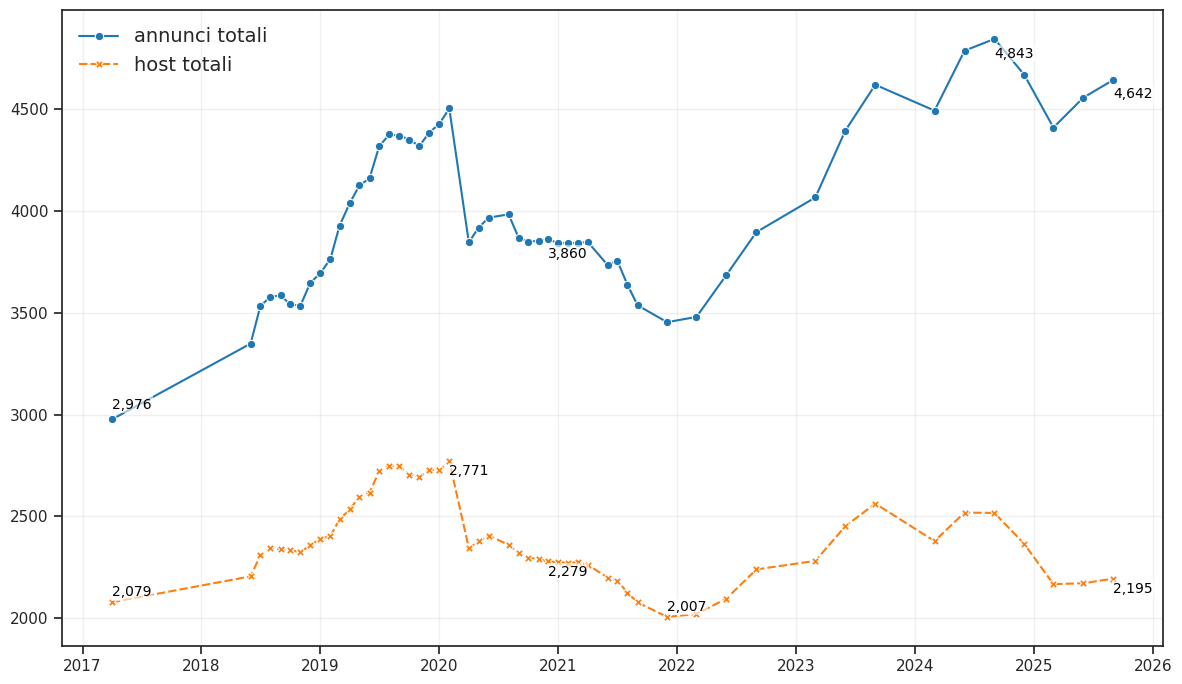

In [5]:
def snsplot(lines):
    sns.set(style="ticks")

    # colori coerenti per le due serie
    palette = {
        "annunci totali": "#1f77b4",  # blu
        "host totali": "#ff7f0e"      # arancione
    }

    plt.figure(figsize=(12,7))
    ax = sns.lineplot(
        data=lines,
        markers=True,
        dashes=True,
        palette=palette
    )

    plt.grid(alpha=0.3)
    plt.legend(title="", prop={'size': 14}, frameon=False)

    # etichette numeriche sui punti principali
    for col in lines.columns:
        y = lines[col]
        x = lines.index
        idxs = [0, len(x)//2, len(x)-1, y.index.get_loc(y.idxmax()), y.index.get_loc(y.idxmin())]
        idxs = sorted(set(idxs))
        for i in idxs:
            offset = 0.02 * (y.max() - y.min())
            va = 'bottom' if i % 2 == 0 else 'top'
            plt.text(
                x[i], y[i] + (offset if va == 'bottom' else -offset),
                f"{y[i]:,.0f}",
                fontsize=10,
                color='black',
                ha='left',
                va=va,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
            )

    plt.tight_layout()



def ids_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    id_count = pd.Series([dfs[i].id.count() for i in range(len(dfs))], index=index)
    #private_room_count = pd.Series([dfs[i][dfs[i].room_type.isin(["Private room", "Shared room"])].id.count() for i in range(len(dfs))], index=index)
    host_count = pd.Series([len(set(dfs[i].host_id)) for i in range(len(dfs))], index=index)
    
    a = "annunci totali"
    #b = "nb of private or shared rooms"
    c = "host totali"
    
    a_lines = id_count.rename(a).to_frame().join(host_count.rename(c).to_frame())
    #    .join(private_room_count.rename(b).to_frame())\
       
    snsplot(a_lines)
    
ids_during_time(dfs, periods)

### It's easy to notice that the growth trend it's way lower for the private / shared rooms announces, compared to the entire apartment / home announces. Let's do a focus on that:

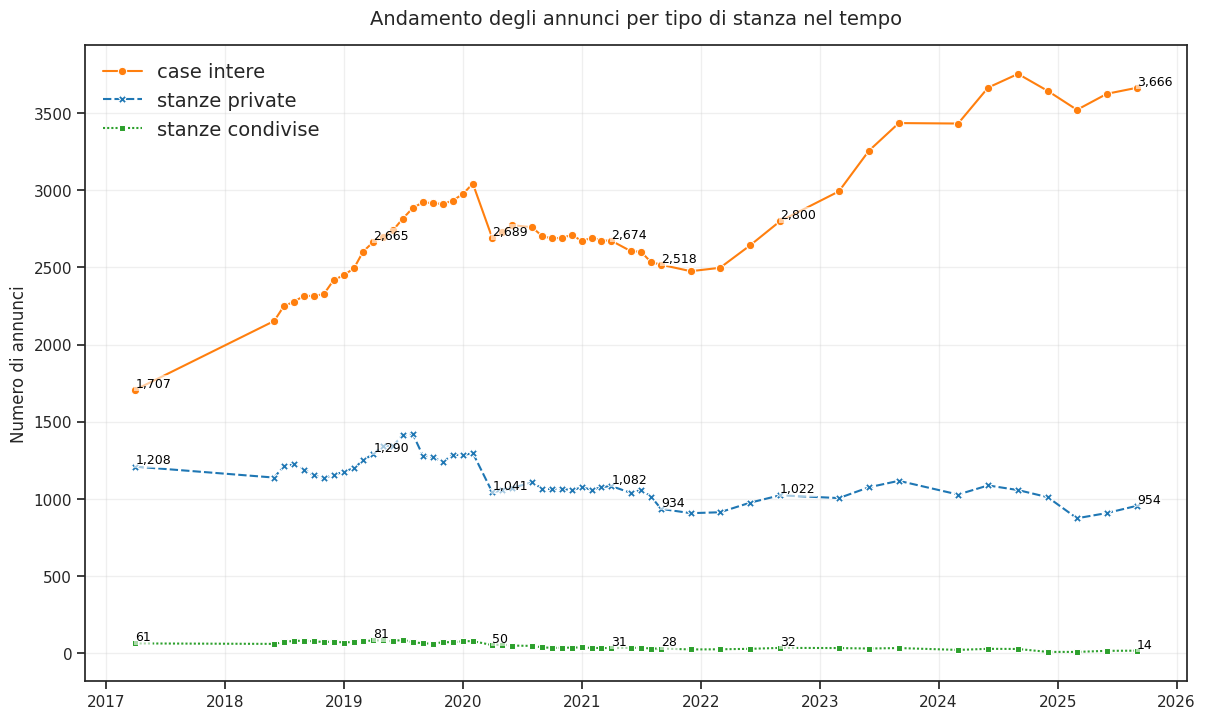

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def snsplot(lines):
    sns.set(style="ticks")

    # 🎨 Palette personalizzata
    palette = {
        "case intere": "#ff7f0e",       # 🟧 arancione
        "stanze private": "#1f77b4",    # 🟦 blu
        "stanze condivise": "#2ca02c"   # 🟩 verde
    }

    plt.figure(figsize=(12,7))
    ax = sns.lineplot(
        data=lines,
        markers=True,
        dashes=True,
        palette=palette
    )

    plt.grid(alpha=0.3)
    plt.legend(title="", prop={'size': 14}, frameon=False)

    # Etichette numeriche ogni ~6 punti
    for col in lines.columns:
        y = lines[col]
        x = lines.index
        step = max(1, len(x)//6)
        for i in range(0, len(x), step):
            plt.text(
                x[i], y.iloc[i],
                f"{y.iloc[i]:,.0f}",
                fontsize=9,
                color='black',
                ha='left',
                va='bottom',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
            )

        # 🔸 Etichetta finale (solo numero, stesso stile)
        last_x = x[-1]
        last_y = y.iloc[-1]
        plt.text(
            last_x, last_y,
            f"{last_y:,.0f}",
            fontsize=9,
            color='black',
            ha='left',
            va='bottom',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
        )

    plt.tight_layout()
    plt.title("Andamento degli annunci per tipo di stanza nel tempo", fontsize=14, pad=15)
    plt.xlabel("")
    plt.ylabel("Numero di annunci")


def type_of_room_during_time(dfs, periods):
    index = pd.DatetimeIndex(periods)

    entire_home_count = pd.Series(
        [dfs[i][dfs[i].room_type.isin(["Entire home/apt"])].id.count() for i in range(len(dfs))],
        index=index
    )
    private_room_count = pd.Series(
        [dfs[i][dfs[i].room_type.isin(["Private room"])].id.count() for i in range(len(dfs))],
        index=index
    )
    shared_room_count = pd.Series(
        [dfs[i][dfs[i].room_type.isin(["Shared room"])].id.count() for i in range(len(dfs))],
        index=index
    )

    b_lines = (
        entire_home_count.rename("case intere").to_frame()
        .join(private_room_count.rename("stanze private").to_frame())
        .join(shared_room_count.rename("stanze condivise").to_frame())
    )

    snsplot(b_lines)


# ▶️ Esegui la funzione
type_of_room_during_time(dfs, periods)


### Here below I removed 2016 / 2017 data so that we can begin the plot from July 2018 -  when Inside Airbnb started doing regular uploads of Bologna's data. 

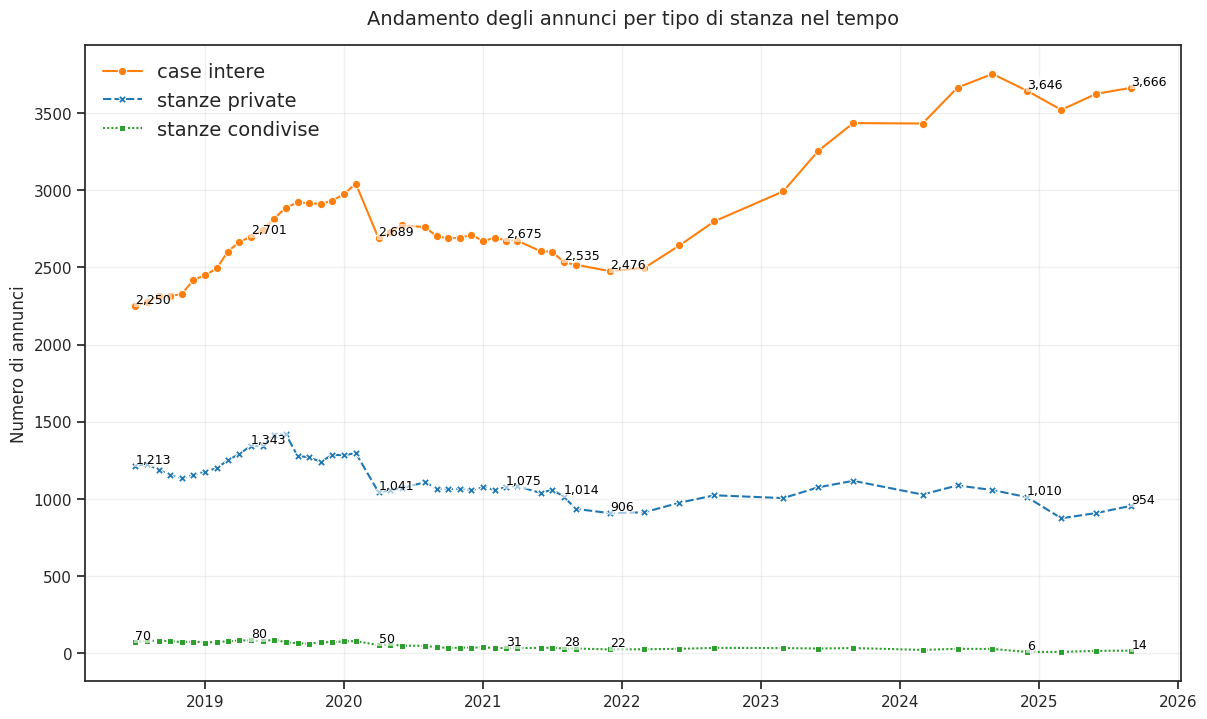

In [7]:
for i in range(2):
    periods.pop(0)
    dfs.pop(0)

type_of_room_during_time(dfs, periods)


### Announces of entire apartments or houses have a stronger impact on city demography, since that means that those houses are entirely dedicated to tourism (there's no inhabitant living there), and they are taken off from real estate market.

### Looking carefully at data, we can notice that not all the announces are active on the platform: plenty of them have no recent review or no review at all (they've probably been uploaded shortly before the Inside Airbnb 'photo'). I tried to take this announces off (choosing a threshold of 6 months for the last review) and voilà: 

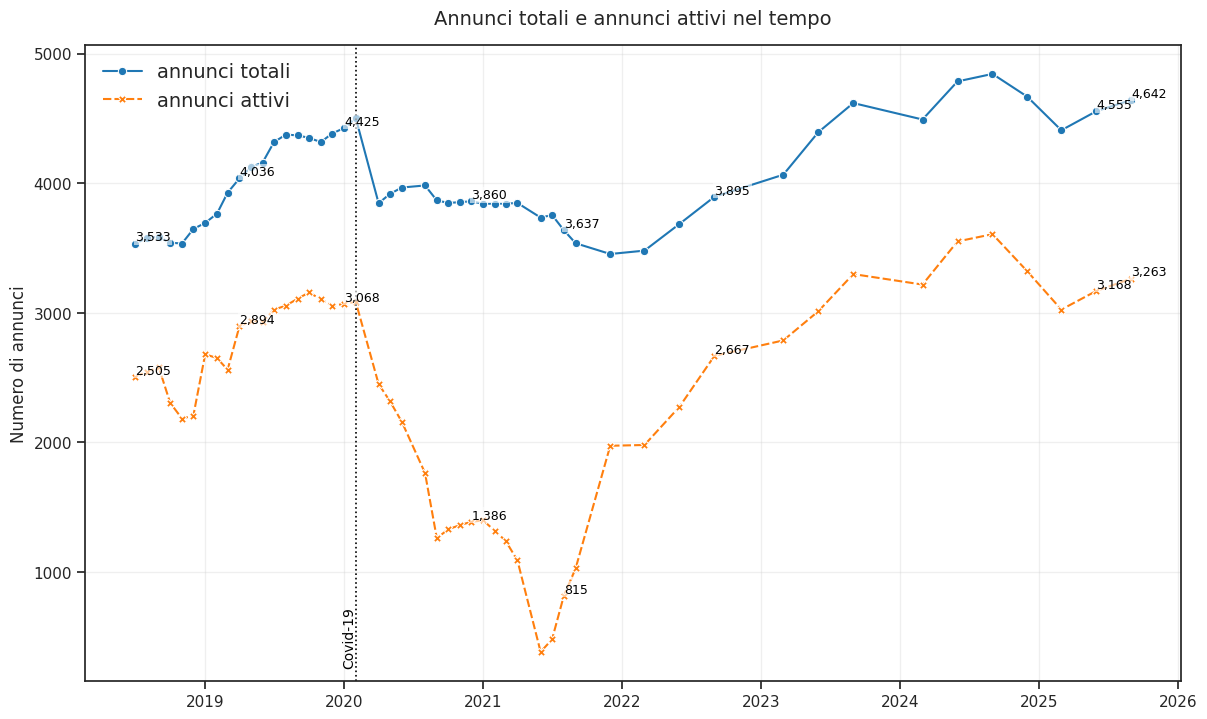

In [8]:
# Trasformo la colonna 'last_review' in datetime
for df in dfs:
    df['last_review'] = df['last_review'].astype('datetime64[ns]')

def active_announces(d, i, periods=periods):  
    threshold = periods[i] - pd.DateOffset(months=6)
    idCount_oldreviews = d[d.last_review < threshold]
    idCount_inactive = d[d.number_of_reviews == 0]
    return (len(d) - (len(idCount_oldreviews) + len(idCount_inactive)))

index = pd.DatetimeIndex(periods)

idCount_total = pd.Series([df.id.count() for df in dfs], index=index)
idCount_active = pd.Series([active_announces(df, i) for i, df in enumerate(dfs)], index=index)

c_lines = (
    idCount_total.rename("annunci totali").to_frame()
    .join(idCount_active.rename("annunci attivi").to_frame())
)

# --- Funzione grafico aggiornata ---
import seaborn as sns
import matplotlib.pyplot as plt

def snsplot(lines):
    sns.set(style="ticks")

    palette = {
        "annunci totali": "#1f77b4",   # blu
        "annunci attivi": "#ff7f0e"    # arancione
    }

    plt.figure(figsize=(12,7))
    ax = sns.lineplot(
        data=lines,
        markers=True,
        dashes=True,
        palette=palette
    )

    plt.grid(alpha=0.3)
    plt.legend(title="", prop={'size': 14}, frameon=False)

    # --- Etichette intermedie e finali ---
    for col in lines.columns:
        y = lines[col]
        x = lines.index
        step = max(1, len(x)//6)
        for i in range(0, len(x), step):
            plt.text(
                x[i], y.iloc[i],
                f"{y.iloc[i]:,.0f}",
                fontsize=9,
                color='black',
                ha='left',
                va='bottom',
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
            )

        # 🔸 Etichetta finale (solo numero)
        last_x = x[-1]
        last_y = y.iloc[-1]
        plt.text(
            last_x, last_y,
            f"{last_y:,.0f}",
            fontsize=9,
            color='black',
            ha='left',
            va='bottom',
            bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=1)
        )

    # --- Linea Covid-19 (febbraio 2020) ---
    covid_date = pd.Timestamp("2020-02-01")
    plt.axvline(covid_date, color="black", linestyle=":", linewidth=1.2)
    plt.text(
        covid_date, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0]) * 0.02,  # in basso
        "Covid-19",
        rotation=90, va='bottom', ha='right', fontsize=10, color='black'
    )

    # --- Titolo e stile ---
    plt.tight_layout()
    plt.title("Annunci totali e annunci attivi nel tempo", fontsize=14, pad=15)
    plt.xlabel("")
    plt.ylabel("Numero di annunci")

# --- Esegui il grafico ---
snsplot(c_lines)


### It turns out that global number of announces is way overestimated. However, our criterion to select active announces relies on reviews, which is quite approximate: not all users leave a review after a stay. In this case, the total number of active announces is probably slightly higher. 
### While I've no clue of why there's a bending between September 2018 and January 2019, It's quite evident that the lockdown was the reason of such inactivity after April 2020. 

### Let's analyse prices. As first, I thought to remove outliers, namely those prices that seem too far from the average prices. Down here we can see some example, under the column 'price':

In [9]:
dfs[-1].sort_values(ascending=False, by=['price']).head(5)

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
3400,1117091584180180502,Mirasole House,543587533,Michael,NaN,Santo Stefano,44.487312,11.341366,Entire home/apt,10000.0,1,0,NaT,NaN,1,365,0,IT037006B4AQFYMDMU
3737,1227917428578577420,in fiera 14 superior,577475654,Pavel,NaN,Santo Stefano,44.497668,11.347664,Entire home/apt,9999.0,1,1,2025-05-11,0.22,1,330,1,IT037006C29D9DGUSS
4057,1344129751713741294,Le Due Torri Apartment,128414276,Andrea,NaN,Santo Stefano,44.495337,11.345550,Entire home/apt,9000.0,2,3,2025-08-29,0.49,1,365,3,IT036007B4US9F53RN
4231,1387426731128486418,Casa tua,685495832,Pavel,NaN,Porto - Saragozza,44.493919,11.332043,Entire home/apt,8000.0,1,1,2025-05-03,0.21,1,206,1,IT037006C2EUZAFYGV
3636,1197984939921259153,Villa im Grünen Civico 2 in Uzzano,577475357,Pavel,NaN,Porto - Saragozza,44.485918,11.302341,Entire home/apt,8000.0,1,0,NaT,NaN,1,25,0,IT047021C2ZBX98PTX


### 9999 euros seems to be an inconsistent price, ok. But what about 5000? Could it be an informal price per month? If so, do they deposit a regular rent contract? Is there any economical benefit to rent a house monthly through Airbnb instead of using traditional channels? Something to look into... 

### Let's remove the outliers. I weight the price with the number of days in which the announce is available, then I exclude the ones that fall off the 98° percentile.

In [10]:
def remove_outliers(period):
    x = period['price'] * period['availability_365'] / 365
    period["price_pond"] = x
    y = period['price']
    return period[y.between(y.quantile(.0001), y.quantile(.98))]

dfs = [remove_outliers(i) for i in dfs]


# formatting datetimes for better captions...

periods_2 = [i.strftime('%Y/%m') for i in periods]

### The next 2 charts show the gap between the biggest players (the top 5 % of hosts with more announces) and those with a single announce (about three quarters of total users). The host-announce distribution draws a sort of zipf curve: very few hosts with a lot of announces, and a long tail of unique-announce hosts. 

In [11]:
def three_val(i, dfs=dfs):
    start = round(len(dfs) / 2) + i
    median = round(len(dfs) / 4)*3 + i
    stop = -3 + i
    if stop>-1:
        raise ValueError(f"take an argument smaller than {i}!")
    return (start, median, stop)

three_val1(2)

NameError: name 'three_val1' is not defined

In [ ]:
print(three_val1())
print(three_val2())
three_val3()

(0, 22, -3)
(22, 11, -2)


(33, 16, -1)

In [ ]:
def three_val(i, dfs=dfs):
    start = round(len(dfs) / 2) + i
    median = round(len(dfs) / 4)*3 + i + 2
    stop = -3 + i
    if stop>-1:
        raise ValueError(f"take an argument smaller than {i}!")
    return (start, median, stop)


def single_host(period):
    
        a = period[period.calculated_host_listings_count == 1]

        percentIncomes = a.price.sum() * 100 / period.price.sum()
        percentAnnounces = a.id.count() * 100 / period.id.count()
        percentHost = len(a.host_id.value_counts()) * 100 / len(period.host_id.value_counts())
        
        return pd.Series([percentHost, percentAnnounces, percentIncomes])

                                      2020/09    2022/03    2023/09
a) % degli host con unico annuncio  75.446234  74.308698  74.615688
b) % dei loro annunci sul totale    45.725594  43.355823  41.788079
c) % dei loro redditi sul totale    41.997347  35.728441  37.914864
                                      2020/08    2021/12    2023/06
a) % degli host con unico annuncio  75.256410  74.068479  74.794069
b) % dei loro annunci sul totale    45.130702  43.482116  42.134571
c) % dei loro redditi sul totale    40.337899  39.810002  38.640560
                                      2020/06    2021/09    2023/03
a) % degli host con unico annuncio  75.936054  74.234322  74.844167
b) % dei loro annunci sul totale    46.448791  44.069264  42.214967
c) % dei loro redditi sul totale    41.816794  38.149417  37.861450


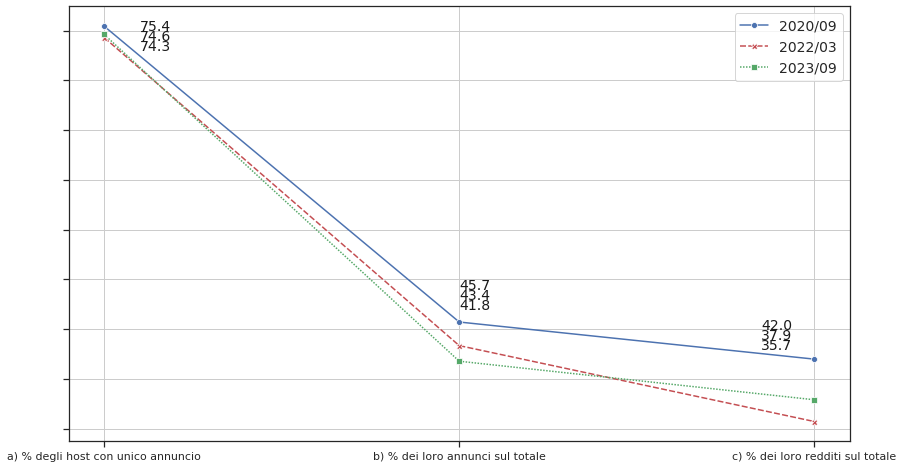

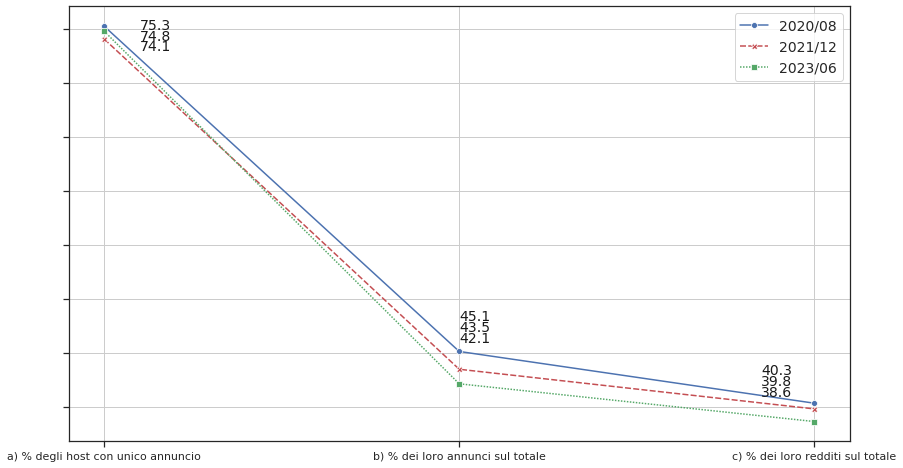

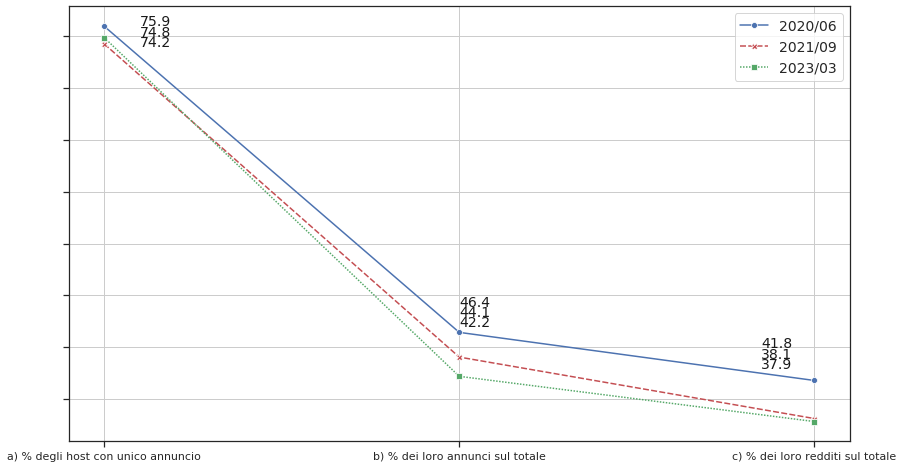

In [ ]:
def scissor_1(thrval, periods=periods_2, scissor=1):
    
    a = []
    for i in thrval:
        a.append(single_host(dfs[i]))
    
    x = pd.Series(["a) % degli host con unico annuncio","b) % dei loro annunci sul totale","c) % dei loro redditi sul totale"])
    plotting(a,thrval,x, scissor)
    
def plotting(a,thrval,x,scissor,periods=periods_2):
    
        lines = a[0].rename(periods[thrval[0]]).to_frame()\
        .join(a[1].rename(periods[thrval[1]]).to_frame())\
        .join(a[2].rename(periods[thrval[2]]).to_frame()).set_index(x)
        print(lines)
        snsplot2(lines, x, scissor)
        
def annotate(l, ax, scissor):
    
    if scissor==1:
        a = sorted(l[l.columns[0]], reverse=True)
        y = round(max(a))
        ax.text(0.1,y-0, round(a[0], 1), color="k", fontsize=14)
        ax.text(0.1,y-1, round(a[1], 1), color="k", fontsize=14)
        ax.text(0.1,y-2, round(a[2], 1), color="k", fontsize=14)
    
        a = sorted(l[l.columns[1]], reverse=True)
        y = round(max(a))
        ax.text(1,y+3, round(a[0], 1), color="k", fontsize=14)
        ax.text(1,y+2, round(a[1], 1), color="k", fontsize=14)
        ax.text(1,y+1, round(a[2], 1), color="k", fontsize=14)
    
        a = sorted(l[l.columns[2]], reverse=True)
        y = round(max(a))
        ax.text(1.85,y+3, round(a[0], 1), color="k", fontsize=14)
        ax.text(1.85,y+2, round(a[1], 1), color="k", fontsize=14)
        ax.text(1.85,y+1, round(a[2], 1), color="k", fontsize=14)
        
    if scissor==2:
        a = sorted(l[l.columns[0]], reverse=True)
        y = round(max(a))
        ax.text(0.1,y-0, round(a[0], 1), color="k", fontsize=14)
        ax.text(0.1,y-0, round(a[1], 1), color="k", fontsize=14)
        ax.text(0.1,y-0, round(a[2], 1), color="k", fontsize=14)
    
        a = sorted(l[l.columns[1]], reverse=True)
        y = round(max(a))
        ax.text(1,y+3, round(a[0], 1), color="k", fontsize=14)
        ax.text(1,y+1.8, round(a[1], 1), color="k", fontsize=14)
        ax.text(1,y+0.7, round(a[2], 1), color="k", fontsize=14)
    
        a = sorted(l[l.columns[2]], reverse=True)
        y = round(min(a))
        ax.text(1.85,y-3, round(a[0], 1), color="k", fontsize=14)
        ax.text(1.85,y-4.2, round(a[1], 1), color="k", fontsize=14)
        ax.text(1.85,y-5.4, round(a[2], 1), color="k", fontsize=14)
    
        
def snsplot2(lines, x, scissor):
    
    l = lines.T
    sns.set(style="ticks")
    dims = (14, 8)
    
    fig, ax = plt.subplots(1,1,figsize=dims)
    #ax.set(ylim =(30, 90))
    ax.set_yticklabels([])

    annotate(l, ax, scissor)


    sns.lineplot(markers=True, dashes=True, data=lines, palette=farbe, legend=False)
    ax.legend(sorted(l.index),prop={'size': 14})
    plt.grid()

    
i = scissor_1(three_val(2))
ii = scissor_1(three_val(1))
iii = scissor_1(three_val(0))

                                    2020/09    2022/03    2023/09
a) top 5% host con più annunci     5.000000   5.000000   5.000000
b) % dei loro annunci sul totale  26.517150  27.398064  30.838852
c) % dei loro ricavi sul totale   40.856142  50.863649  46.742447
                                    2020/08    2021/12    2023/06
a) top 5% host con più annunci     5.000000   5.000000   5.000000
b) % dei loro annunci sul totale  26.781138  26.751404  30.580046
c) % dei loro ricavi sul totale   41.506355  43.662381  46.725420
                                    2020/06    2021/09    2023/03
a) top 5% host con più annunci     5.000000   5.000000   5.000000
b) % dei loro annunci sul totale  26.145136  26.666667  30.537418
c) % dei loro ricavi sul totale   38.966897  47.620764  48.735156


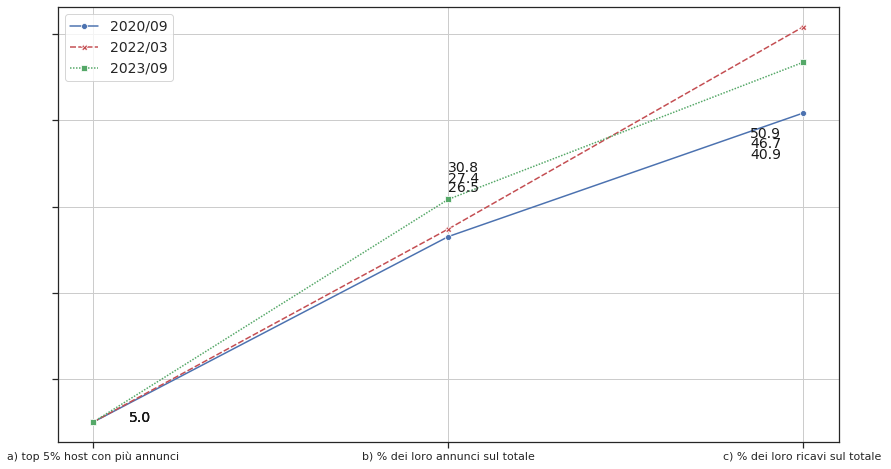

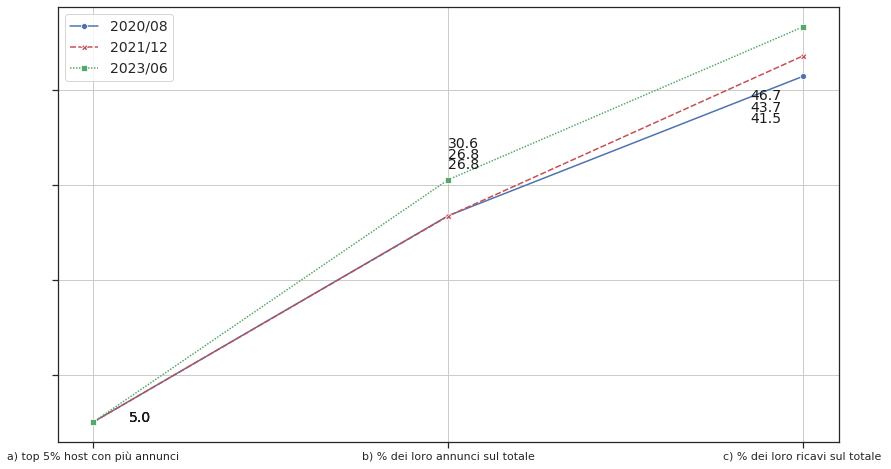

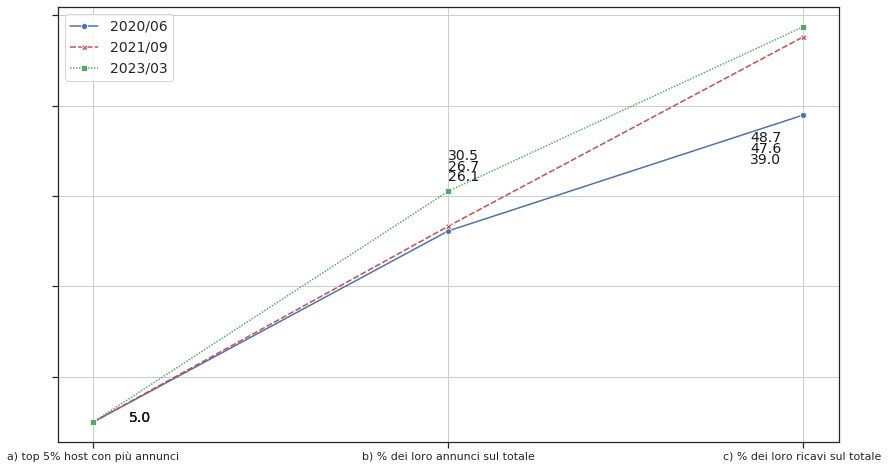

In [ ]:
def incomes_rate(period, nHosts):
    
    g = period.groupby("host_id")['price_pond'].sum().sort_values(ascending=False)
    h = period.groupby("host_id")['id'].count().sort_values(ascending=False)
    
    percentAnnounces = h[:nHosts].sum() * 100 / period.id.count()
    percentIncomes = g[:nHosts].sum() * 100 / g.sum()
    
    return pd.Series([5, percentAnnounces, percentIncomes])


def five_percent(period):          
    return int(round(len(period["host_id"].value_counts()) / 20))


def scissor_2(thrval, periods=periods_2, scissor=2):
    
    a = []
    for i in thrval:
        a.append(incomes_rate(dfs[i], five_percent(dfs[i])))

    
    x = pd.Series(["a) top 5% host con più annunci", "b) % dei loro annunci sul totale" ,"c) % dei loro ricavi sul totale "])
    
    plotting(a,thrval,x, scissor)
    
    
i = scissor_2(three_val(2))
ii = scissor_2(three_val(1))
iii = scissor_2(three_val(0))

### This is one of the few trends that is even corroborated after the lockdown: announces and incomes tend to be concentrated over time.

### Next, a couple of barplots that show prices and announces count trends over time per neighbourhood.

In [ ]:
def five_val(dfs=dfs):
    first = round(len(dfs) / 2)
    half = round(round(len(dfs) / 2) / 2)
    second = first + half
    third  = second + round(half/2)
    return [first, second, third,-3 ,-1]

five_val()

[22, 33, 39, -3, -1]

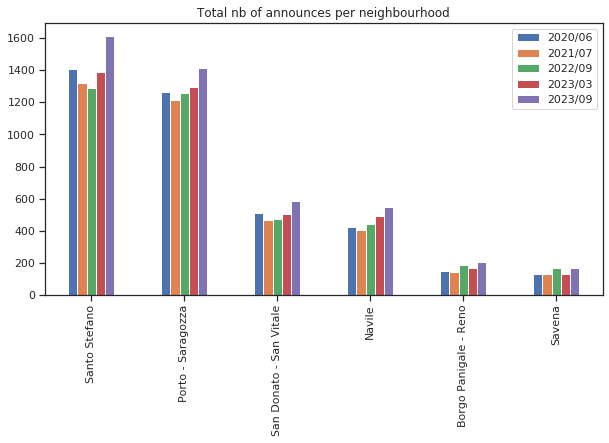

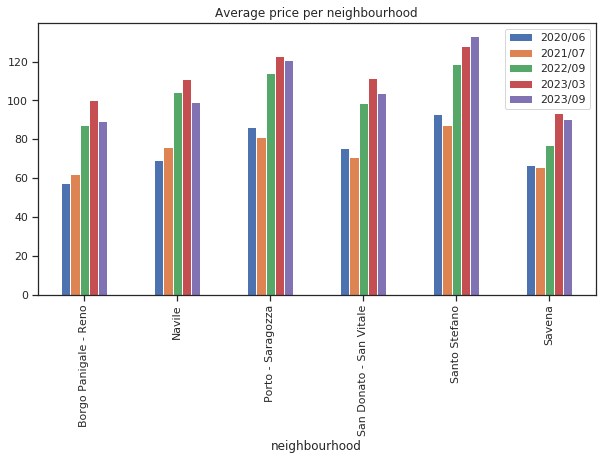

In [ ]:

def plotting2(series, title, i=five_val(), dfs=dfs, periods=periods_2):
    
    graph_df = series[0].rename(periods[i[0]]).to_frame()\
    .join(series[1].rename(periods[i[1]]).to_frame())\
    .join(series[2].rename(periods[i[2]]).to_frame())\
    .join(series[3].rename(periods[i[3]]).to_frame())\
    .join(series[4].rename(periods[i[4]]).to_frame())
    graph_df.plot(kind='bar',figsize=(10, 5), title=title)
    
    
def neigh_id_count(ils=five_val(), dfs=dfs):
    return [dfs[i]['neighbourhood'].value_counts(normalize=False) for i in ils]


def neigh_average_price(ils=five_val(), dfs=dfs):
    return [dfs[i].groupby("neighbourhood")['price'].mean() for i in ils]
        

plotting2(neigh_id_count(), "Total nb of announces per neighbourhood")
plotting2(neigh_average_price(), "Average price per neighbourhood")

### And that's all for now! Please feel free to write me in case you find any relevant flaw in statistics. I really hope someone find this code useful to study Airbnb across other cities. Ciao!


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


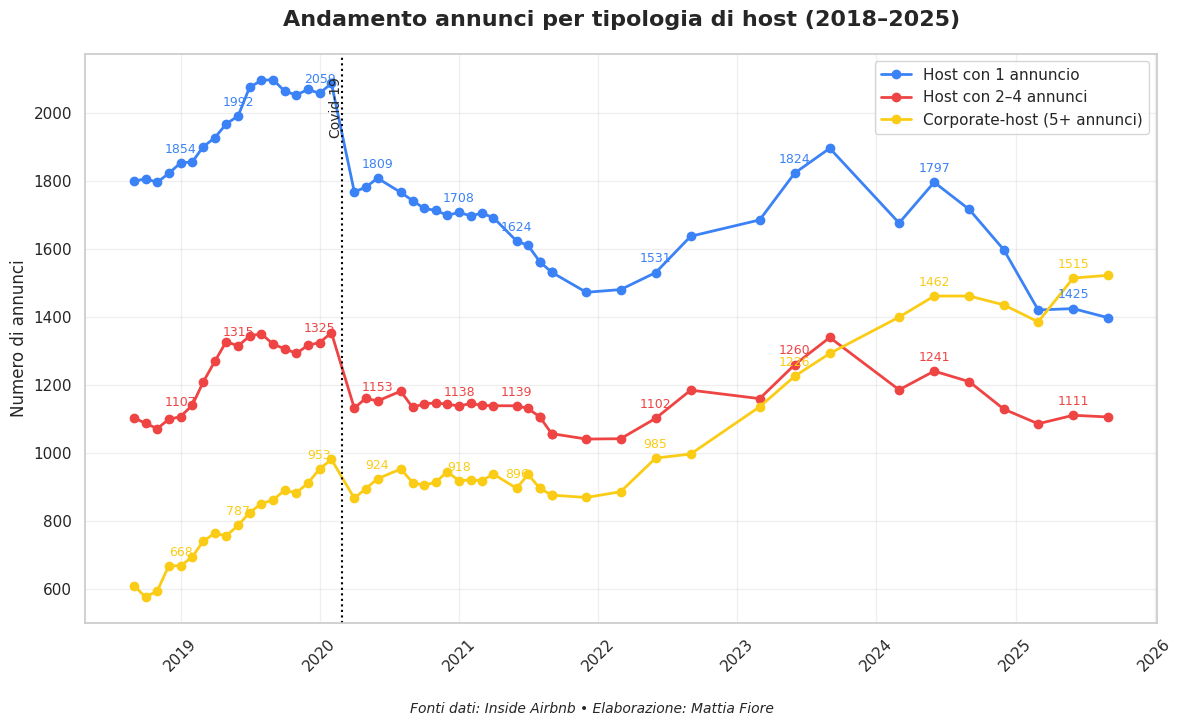

In [ ]:
# ================================
# GRAFICO: Andamento annunci per tipologia di host (2020–2025)
# ================================

sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

palette = {
    "Host con 1 annuncio": "#3b82f6",   # blu
    "Host con 2–4 annunci": "#ef4444",  # rosso
    "Corporate-host (5+ annunci)": "#facc15"  # giallo
}

for col in host_type_trend.columns:
    plt.plot(
        host_type_trend.index, 
        host_type_trend[col],
        marker='o', 
        label=col, 
        color=palette[col], 
        linewidth=2
    )
    # etichette numeriche su alcuni punti
    for x, y in zip(host_type_trend.index, host_type_trend[col]):
        if x.month in [1, 6]:  # mostra etichette ogni 6 mesi
            plt.text(x, y + 30, f"{int(y)}", ha='center', fontsize=9, color=palette[col])

# Linea verticale per Covid
plt.axvline(pd.Timestamp("2020-03-01"), color="black", linestyle=":", linewidth=1.5)
plt.text(pd.Timestamp("2020-03-01"), plt.ylim()[1]*0.97, "Covid-19", rotation=90,
         va='top', ha='right', fontsize=10)

# Titolo e legenda
plt.title("Andamento annunci per tipologia di host (2018–2025)", fontsize=16, weight='bold', pad=20)
plt.ylabel("Numero di annunci", fontsize=12)
plt.xlabel("")
plt.xticks(rotation=45)
plt.legend(title="", fontsize=11)
plt.grid(alpha=0.3)

# Fonte dati
plt.figtext(0.5, -0.03, "Fonti dati: Inside Airbnb • Elaborazione: Mattia Fiore", 
            ha="center", fontsize=10, style='italic')

plt.tight_layout()
plt.show()



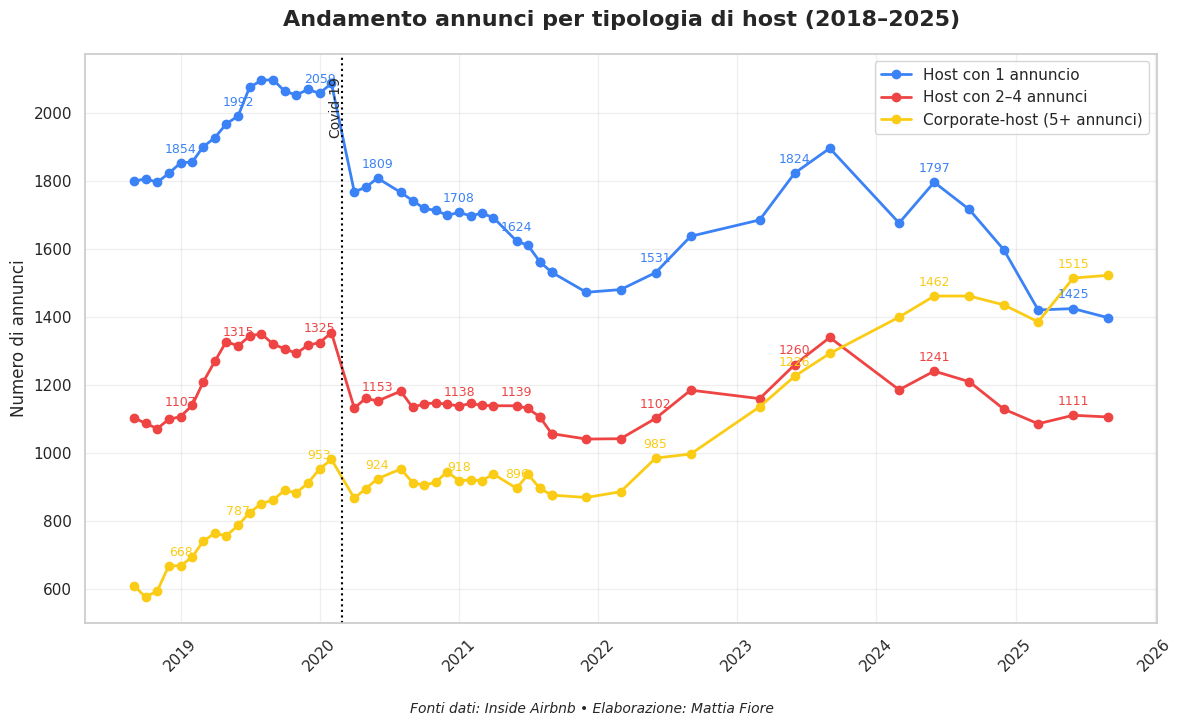

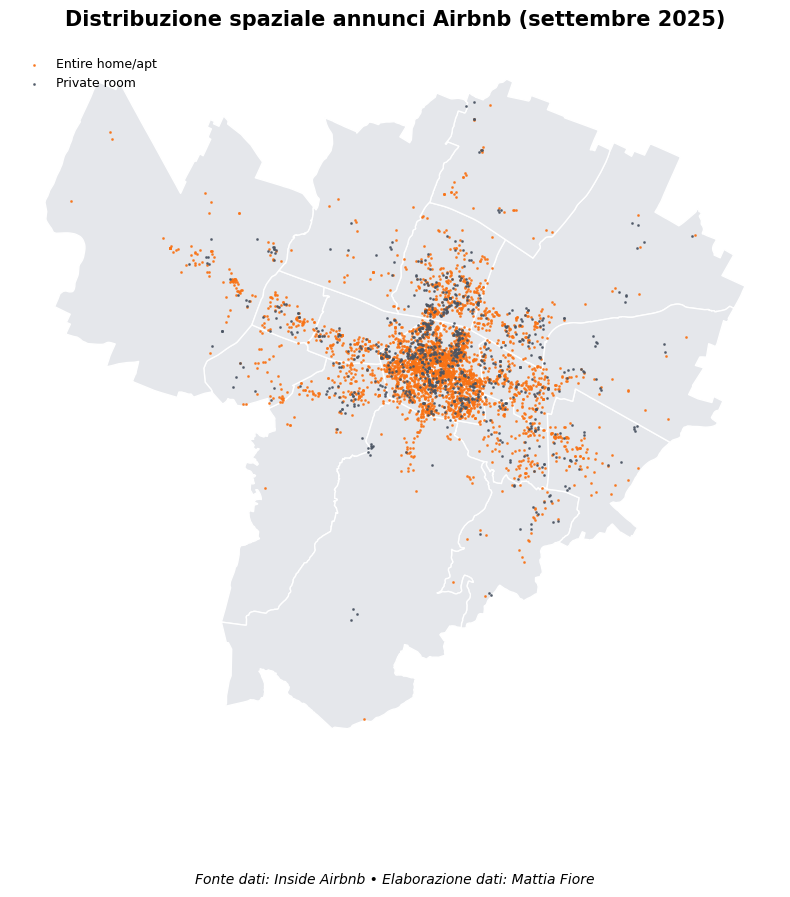

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# === 1. CARICA I DATI ===
# confini del comune
neigh = gpd.read_file('gis_data/zone-del-comune-di-bologna (2).geojson')

# dati Airbnb (scegli il CSV più recente o quello che vuoi mappare)
df = pd.read_csv('listings/9_2025.csv')

# crea GeoDataFrame con coordinate
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# === 2. FILTRA SE NECESSARIO ===
# escludi valori mancanti o fuori mappa
gdf = gdf.dropna(subset=['latitude', 'longitude'])

# === 3. STILE E COLORI ===
colors = {
    "Entire home/apt": "#f97316",   # arancione (come il tuo)
    "Private room": "#4b5563"       # grigio scuro
}

# === 4. CREA LA MAPPA ===
fig, ax = plt.subplots(figsize=(8, 10))
neigh.plot(ax=ax, color="#e5e7eb", edgecolor="white")
for room, color in colors.items():
    subset = gdf[gdf["room_type"] == room]
    subset.plot(ax=ax, markersize=1, color=color, label=room, alpha=0.8)

# === 5. TITOLO E LEGENDA ===
plt.title("Distribuzione spaziale annunci Airbnb (settembre 2025)",
          fontsize=15, fontweight='bold', pad=15)
plt.legend(title="", loc="upper left")
plt.axis("off")

# === 6. FONTE DATI ===
plt.figtext(0.5, 0.02, "Fonte dati: Inside Airbnb • Elaborazione dati: Mattia Fiore",
            ha="center", fontsize=10, style="italic")

plt.tight_layout()
plt.show()


In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# === 1. Carica i dati ===
neigh = gpd.read_file('gis_data/zone-del-comune-di-bologna (2).geojson')
df = pd.read_csv('listings/9_2025.csv')

# Crea GeoDataFrame dei punti Airbnb
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.longitude, df.latitude),
    crs="EPSG:4326"
)

# === 2. Allinea CRS (sistema di coordinate) ===
neigh = neigh.to_crs("EPSG:4326")

# === 3. Unisci punti e poligoni ===
joined = gpd.sjoin(gdf, neigh, how="inner", predicate="within")

# === 4. Conta gli annunci per zona ===
counts = joined.groupby('nomezona').size().reset_index(name='num_annunci')


In [ ]:
neigh = neigh.merge(counts, on='nomezona', how='left')
neigh['num_annunci'] = neigh['num_annunci'].fillna(0)


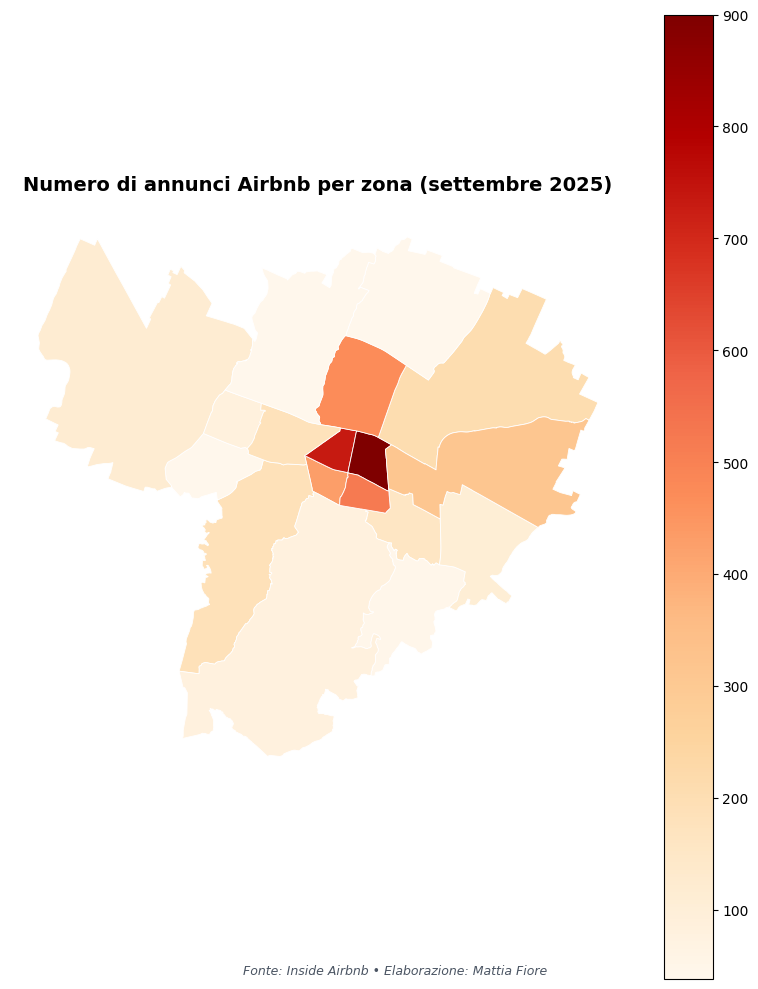

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))
neigh.plot(
    column='num_annunci',
    cmap='OrRd',          # scala di colori da chiaro a rosso
    linewidth=0.6,
    edgecolor='white',
    legend=True,
    ax=ax
)

plt.title("Numero di annunci Airbnb per zona (settembre 2025)",
          fontsize=14, fontweight="bold", pad=15)
plt.axis("off")

plt.figtext(0.5, 0.02,
            "Fonte: Inside Airbnb • Elaborazione: Mattia Fiore",
            ha="center", fontsize=9, style="italic", color="#4b5563")

plt.tight_layout()
plt.show()


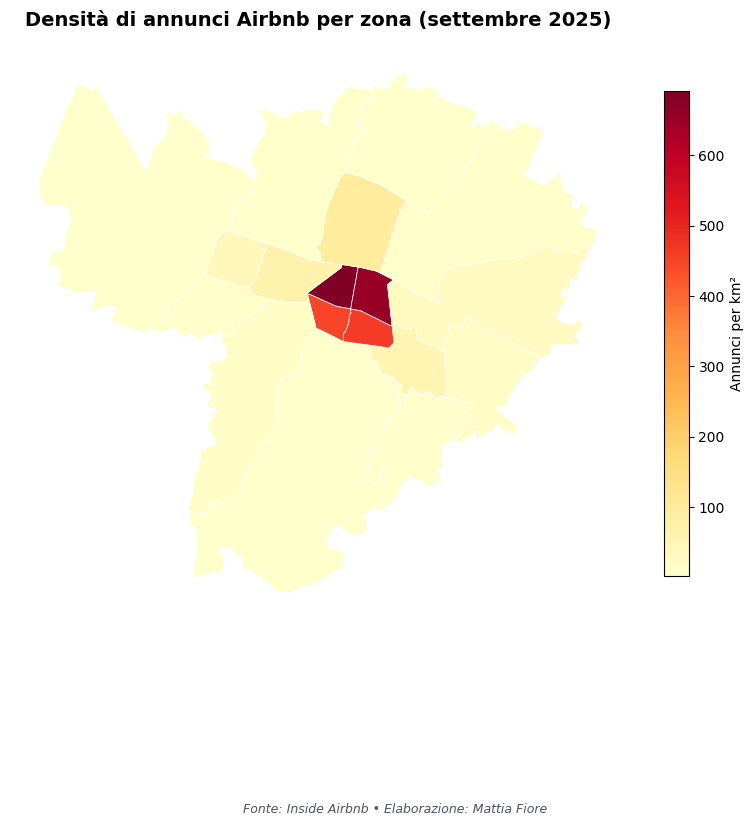

In [ ]:
# Proietta in un sistema metrico (UTM 32N, usato per l’Italia settentrionale)
neigh_m = neigh.to_crs(epsg=32632)

# Calcola area in km²
neigh_m['area_km2'] = neigh_m.area / 1_000_000

# Densità di annunci per km²
neigh_m['densità_annunci'] = neigh_m['num_annunci'] / neigh_m['area_km2']

fig, ax = plt.subplots(figsize=(8, 10))
neigh_m.plot(
    column='densità_annunci',
    cmap='YlOrRd',
    linewidth=0.5,
    edgecolor='white',
    legend=True,
    legend_kwds={'shrink': 0.5, 'label': 'Annunci per km²'},
    ax=ax
)

plt.title("Densità di annunci Airbnb per zona (settembre 2025)",
          fontsize=14, fontweight="bold", pad=15)
plt.axis("off")

plt.figtext(0.5, 0.02,
            "Fonte: Inside Airbnb • Elaborazione: Mattia Fiore",
            ha="center", fontsize=9, style="italic", color="#4b5563")

plt.tight_layout()
plt.show()

In [ ]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gaussian_kde

# Carica i dati Airbnb
df = pd.read_csv('listings/9_2025.csv')

# Crea GeoDataFrame dei punti
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

# Proietta in coordinate metriche (metri)
gdf = gdf.to_crs(epsg=32632)

# Carica confini della città
neigh = gpd.read_file('gis_data/zone-del-comune-di-bologna (2).geojson').to_crs(epsg=32632)


In [ ]:
# Estrai coordinate
x = gdf.geometry.x
y = gdf.geometry.y

# Crea una griglia regolare per la densità
xmin, ymin, xmax, ymax = gdf.total_bounds
xx, yy = np.mgrid[xmin:xmax:500j, ymin:ymax:500j]

# Calcola la densità kernel
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)


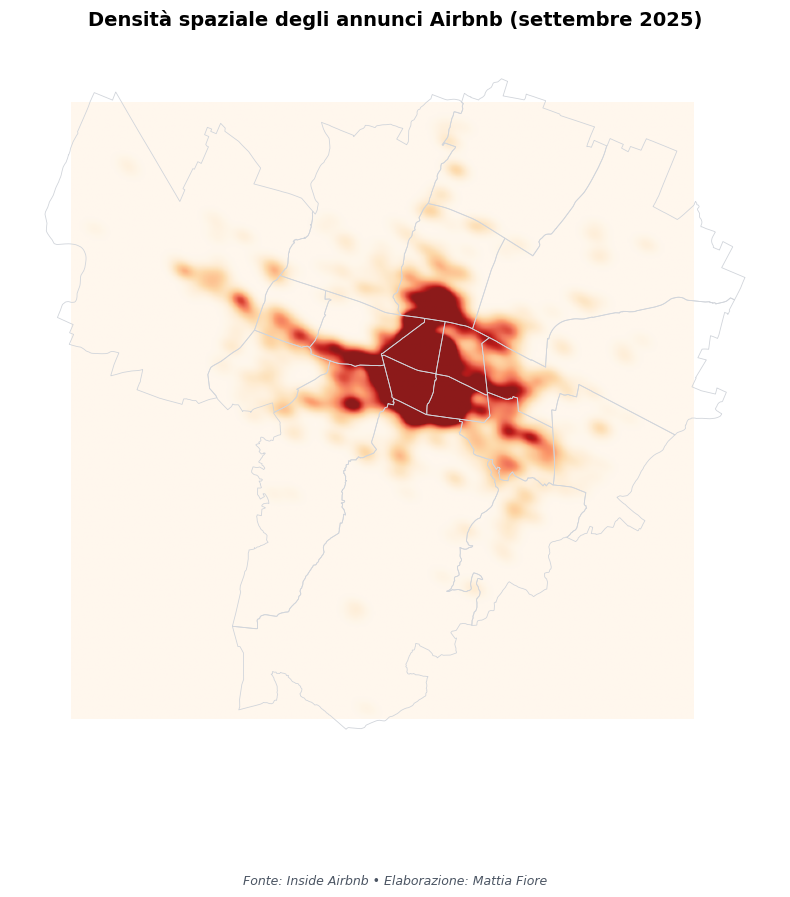

In [ ]:
fig, ax = plt.subplots(figsize=(8, 10))

# 1️⃣ Disegna la heatmap per prima
ax.imshow(
    np.rot90(f),
    cmap="OrRd",
    extent=[xmin, xmax, ymin, ymax],
    alpha=0.9,          # trasparenza più alta per dare corpo
    vmin=f.min(),
    vmax=f.max() / 8
)

# 2️⃣ Aggiungi i confini sopra, ma trasparenti (solo contorno)
neigh.boundary.plot(ax=ax, color="#d1d5db", linewidth=0.6)

# 3️⃣ Titolo e fonte
plt.title("Densità spaziale degli annunci Airbnb (settembre 2025)",
          fontsize=14, fontweight="bold", pad=15)
plt.axis("off")

plt.figtext(0.5, 0.02,
            "Fonte: Inside Airbnb • Elaborazione: Mattia Fiore",
            ha="center", fontsize=9, style="italic", color="#4b5563")

plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# --- util ---
def winsorize(s, p_low=0.001, p_high=0.99):
    lo, hi = s.quantile(p_low), s.quantile(p_high)
    return s.clip(lo, hi)

def is_active(df, ts, months=6):
    """Restituisce maschera booleana per annunci attivi negli ultimi 'months' mesi."""
    thr = ts - pd.DateOffset(months=months)
    # almeno una recensione recente O qualche giorno disponibile
    recent_rev = df['last_review'].ge(thr) & df['number_of_reviews'].gt(0)
    some_avail = df['availability_365'].gt(0)
    return (recent_rev | some_avail)

def host_bins(count):
    if count == 1: return "1"
    if 2 <= count <= 4: return "2-4"
    return "5+"

def gini(x):
    x = np.asarray(x, dtype=float)
    if x.size == 0: return np.nan
    x = x[x >= 0]
    if x.sum() == 0: return 0.0
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    return (n + 1 - 2 * (cumx / cumx[-1]).sum()) / n

def hhi(shares):
    return np.sum((np.asarray(shares)) ** 2)

def make_panel(dfs, periods):
    rows = []
    for df, ts in zip(dfs, pd.to_datetime(periods)):
        d = df.copy()

        # normalizza colonne chiave
        d['last_review'] = pd.to_datetime(d['last_review'], errors='coerce')
        d['price'] = pd.to_numeric(d['price'], errors='coerce')
        d['availability_365'] = pd.to_numeric(d['availability_365'], errors='coerce').fillna(0)

        # filtra prezzi outlier
        d['price'] = winsorize(d['price'])

        # annunci attivi
        active_mask = is_active(d, ts, months=6)
        d_active = d[active_mask]

        # room types
        rt = d['room_type'].value_counts()
        n_entire = int(rt.get('Entire home/apt', 0))
        n_priv = int(rt.get('Private room', 0))
        n_shared = int(rt.get('Shared room', 0))

        # host-type counts
        listings_per_host = d.groupby('host_id')['id'].count()
        bins = listings_per_host.map(host_bins)
        ann_by_type = (
            listings_per_host
            .groupby(bins)
            .sum()
            .reindex(['1', '2-4', '5+'])
            .fillna(0)
            .astype(int)
        )

        # ricavi proxy
        d['rev_proxy'] = d['price'] * d['availability_365'] / 365
        rev_per_host = d.groupby('host_id')['rev_proxy'].sum().sort_values(ascending=False)

        # top 5%
        n_hosts = listings_per_host.size
        topk = max(1, int(round(n_hosts * 0.05)))
        share_ann_top5 = d.groupby('host_id')['id'].count().nlargest(topk).sum() / len(d)
        share_rev_top5 = rev_per_host.iloc[:topk].sum() / rev_per_host.sum() if rev_per_host.sum() > 0 else np.nan

        # HHI e Gini
        shares_rev = (rev_per_host / rev_per_host.sum()).fillna(0).values
        hhi_rev = hhi(shares_rev)
        gini_rev = gini(rev_per_host.values)

        rows.append({
            'ts': ts,
            'annunci_totali': len(d),
            'annunci_attivi': int(d_active.shape[0]),
            'host_totali': int(listings_per_host.size),

            'entire': n_entire,
            'private': n_priv,
            'shared': n_shared,

            'annunci_host_1': int(ann_by_type['1']),
            'annunci_host_2_4': int(ann_by_type['2-4']),
            'annunci_host_5p': int(ann_by_type['5+']),

            'share_ann_top5': float(share_ann_top5),
            'share_rev_top5': float(share_rev_top5),
            'hhi_rev': float(hhi_rev),
            'gini_rev': float(gini_rev)
        })

    panel = pd.DataFrame(rows).set_index('ts').sort_index()
    cross = panel[panel['annunci_host_5p'] > panel['annunci_host_1']]
    first_cross = cross.index.min() if not cross.empty else None
    return panel, first_cross

# esecuzione
panel, first_cross = make_panel(dfs, periods)
print("Primo sorpasso corporate > single:", first_cross)


/tmp/ipykernel_13130/1756912985.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d['last_review'] = pd.to_datetime(d['last_review'], errors='coerce')
/tmp/ipykernel_13130/1756912985.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d['last_review'] = pd.to_datetime(d['last_review'], errors='coerce')
/tmp/ipykernel_13130/1756912985.py:41: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  d['last_review'] = pd.to_datetime(d['last_review'], errors='coerce')
/tmp/ipykernel_13130/1756912985.py:41: UserWarning: Could not infer format, so each element will be parsed individuall

Primo sorpasso corporate > single: 2025-03-01 00:00:00


In [ ]:
import geopandas as gpd
import pandas as pd
import numpy as np

# === 1. carica i dati ===
zones = gpd.read_file("gis_data/zone-del-comune-di-bologna (2).geojson").to_crs("EPSG:4326")
df = pd.read_csv("listings/9_2025.csv")

# === 2. prepara il dataframe Airbnb ===
df["price"] = pd.to_numeric(df["price"], errors="coerce")
df["availability_365"] = pd.to_numeric(df["availability_365"], errors="coerce").fillna(0)
df["host_id"] = df["host_id"].astype(str)
df["geometry"] = gpd.points_from_xy(df.longitude, df.latitude)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326")

# === 3. join spaziale per assegnare ogni annuncio alla zona ===
joined = gpd.sjoin(gdf, zones, how="inner", predicate="within")

# === 4. calcoli per zona ===
# totale annunci
tot_annunci = len(joined)
# proxy di "volume d'affari" (prezzo * disponibilità / 365)
joined["rev_proxy"] = joined["price"] * joined["availability_365"] / 365

# conteggio annunci per host
host_counts = joined.groupby("host_id")["id"].count()
corporate_host_ids = host_counts[host_counts >= 5].index

# flag corporate
joined["is_corporate"] = joined["host_id"].isin(corporate_host_ids)

# aggregazioni per zona
tab = joined.groupby("nomezona").agg(
    Annunci=("id", "count"),
    VolumeAffari=("rev_proxy", "sum"),
    CorporateHost=("is_corporate", "mean")  # % corporate host
).reset_index()

# calcoli delle % sul totale
tab["% sul totale"] = 100 * tab["Annunci"] / tot_annunci
tab["% volume di affari"] = 100 * tab["VolumeAffari"] / tab["VolumeAffari"].sum()
tab["% corporate host nel quartiere"] = 100 * tab["CorporateHost"]

# seleziona e formatta colonne
tab = tab[[
    "nomezona", "Annunci", "% sul totale", "% volume di affari", "% corporate host nel quartiere"
]].rename(columns={"nomezona": "Zona"})

# arrotondamenti
tab["% sul totale"] = tab["% sul totale"].round(2)
tab["% volume di affari"] = tab["% volume di affari"].round(2)
tab["% corporate host nel quartiere"] = tab["% corporate host nel quartiere"].round(2)

# === 5. ordina per numero di annunci e visualizza ===
tab = tab.sort_values(by="Annunci", ascending=False).reset_index(drop=True)

print("\nAnnunci per zone di Bologna – settembre 2025")
display(tab)

# se vuoi salvarla in Excel o CSV:
# tab.to_csv("bologna_zones_2025_09.csv", index=False)



Annunci per zone di Bologna – settembre 2025


,Zona,Annunci,% sul totale,% volume di affari,% corporate host nel quartiere
0,Irnerio,900,19.39,23.79,43.33
1,Marconi,732,15.77,15.97,50.55
2,Galvani,520,11.20,14.77,38.85
3,Bolognina,470,10.12,8.96,39.79
4,Malpighi,429,9.24,8.95,37.30
5,S. Vitale,312,6.72,6.49,32.05
6,San Donato,209,4.50,5.38,31.10
7,Costa Saragozza,183,3.94,2.95,41.53
8,Saffi,180,3.88,2.40,41.67
9,Murri,156,3.36,2.33,32.05


In [ ]:
import pandas as pd

# === 1. carica il dataset più recente ===
df = pd.read_csv("listings/9_2025.csv")

# === 2. conta gli annunci per host ===
host_counts = df.groupby(["host_id", "host_name"])["id"].count().reset_index(name="Listings")

# === 3. filtra solo i 'corporate host' (5 o più annunci) ===
corporate_hosts = host_counts[host_counts["Listings"] >= 5]

# === 4. ordina in ordine decrescente ===
corporate_hosts = corporate_hosts.sort_values(by="Listings", ascending=False).reset_index(drop=True)

# === 5. seleziona e rinomina le colonne ===
tab_corporate = corporate_hosts[["host_name", "Listings"]].rename(columns={"host_name": "Host Name"})

# === 6. mostra o salva ===
print("\nElenco dei principali corporate host a Bologna (settembre 2025)")
display(tab_corporate.head(15))  # mostra i primi 15

# se vuoi salvarla come CSV o Excel:
# tab_corporate.to_csv("corporate_hosts_bologna_2025_09.csv", index=False)
# tab_corporate.to_excel("corporate_hosts_bologna_2025_09.xlsx", index=False)



Elenco dei principali corporate host a Bologna (settembre 2025)


,Host Name,Listings
0,Wonderful Italy Emilia-Romagna,182
1,Realkasa,95
2,Patrizio,73
3,Welcome To Emilia Romagna & Marche!,58
4,Rino,57
5,Luca,56
6,Michele,55
7,Design Club Collection,36
8,Arianna,32
9,Rambaldo,30
